<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

<div class="alert alert-info">
<h2> План<a class="tocSkip"> </h2>

1. Импортируем библиотеки
 
2. Загружаем данные из файлов
    
3. Изучаем общую информацию о данных
    
4. Найдем выбросы в данных

5. Разложим временной ряд на тренд, сезонность и остаток

6. Добавим новые признаки

7. Сформируем выборки для обучения
    
8. Инициализируем модели LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor
     
9. Протестируем лучшую модель на тестовой выборке и сравним RMSE с константной моделью

10. Делаем выводы по результатам проведенной загрузки данных    
</div>

In [22]:
# импортируем библиотеки
# импорты из стандартной библиотеки

import sklearn

# импорты сторонних библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# импорты модулей текущего проекта

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [23]:
# загружаем данные из файлов

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [24]:
#выведим на экран общую информацию о данных

display(data)
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [25]:
# отсортируем индексы в хронологическом порядке

data.sort_index(inplace=True)

# сгруппируем значения в часовой интервал  

data = data.resample('1H').sum()

In [26]:
# проверяем

display(data)
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [27]:
# проверяем факт хронологии в индексе

print(data.index.is_monotonic)

True


## Анализ

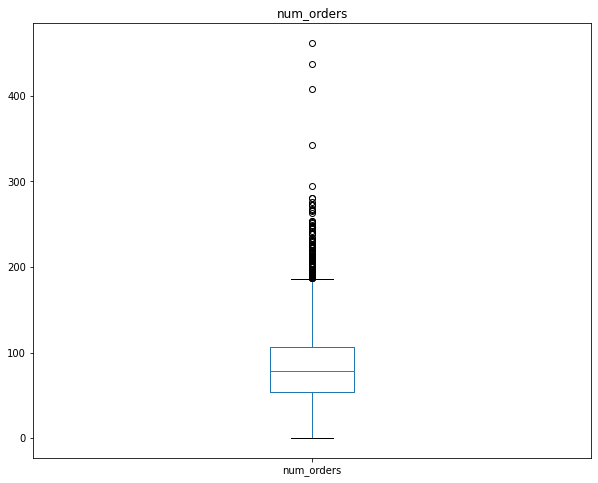

In [28]:
# построим boxplot количественных признаков

data.plot(kind='box', title='num_orders',figsize=(10,8));

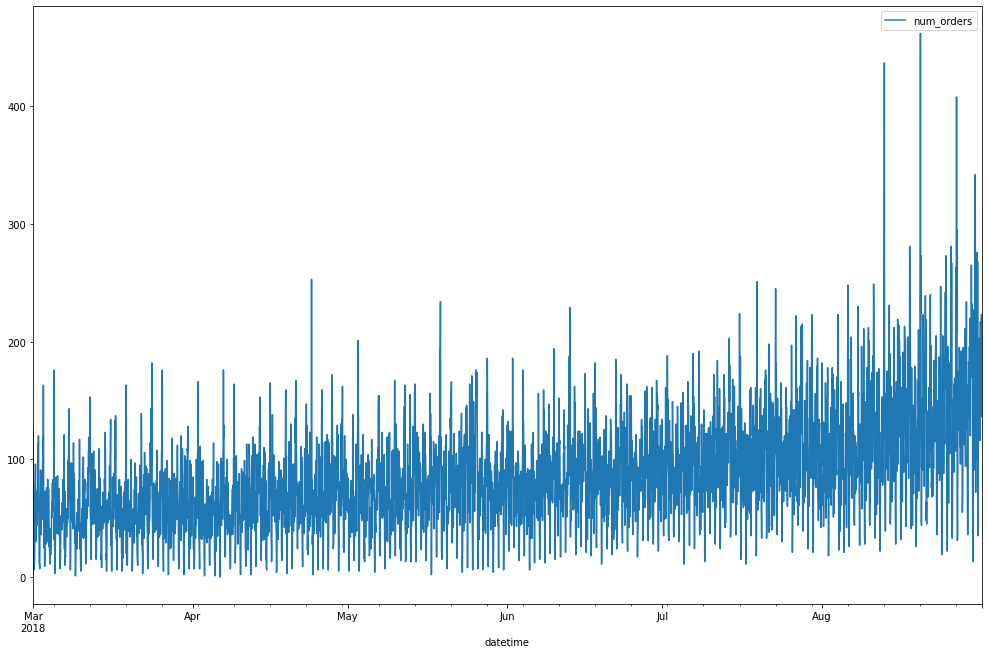

In [29]:
# построим график временного ряда

data.plot(figsize=(17, 11));


Text(0.5, 1.0, 'Остаток')

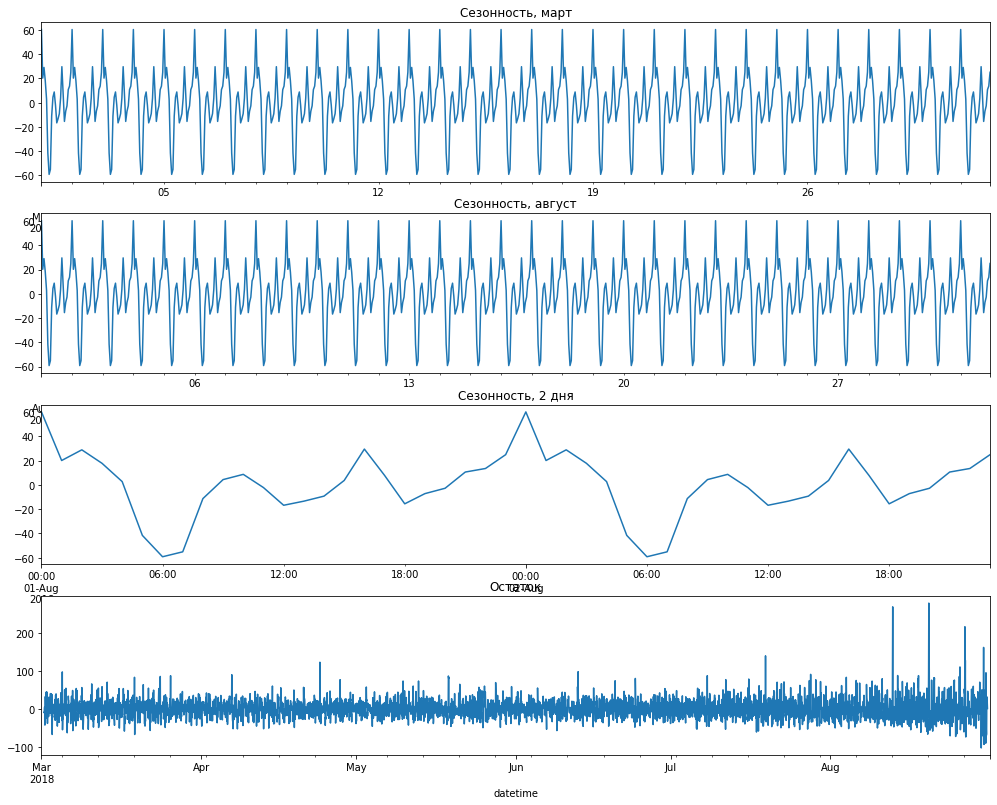

In [30]:
# разложим временной ряд на тренд, сезонность и остаток

decomposed = seasonal_decompose(data)

plt.figure(figsize=(17, 17))

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(512)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Сезонность, март')

plt.subplot(513)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность, август')

plt.subplot(514)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Сезонность, 2 дня')

plt.subplot(515)

decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')

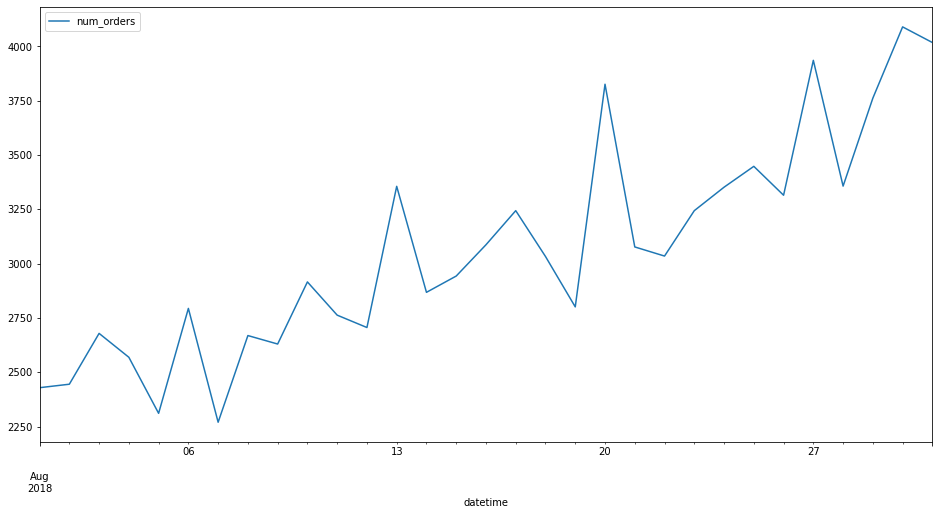

In [31]:
# сгруппируем значения в дневной интервал и выведим график за месяц

data_day = data.resample('1D').sum()
data_day.sort_index(inplace=True)
data_day['2018-08-01':'2018-09-30'].plot(figsize=(16, 8));

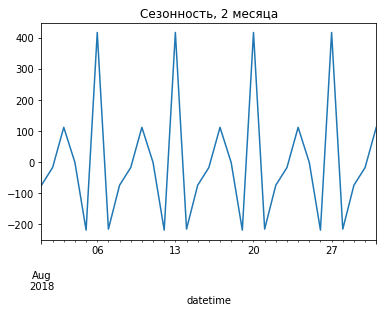

In [32]:
decomposed_day = seasonal_decompose(data_day['2018-08-01':'2018-09-30'])
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность, 2 месяца');

<div class="alert alert-block alert-info">
<h2> Выводы. Подготовка и анализ данных.<a class="tocSkip"> </h2>
    
1. Тренд восходящий, стохастический процесс нестационарный.

2. Наблюдаем сезонность на ежедневной основе с пиками утром, в обед и ночью, что связано рабочим траффиком и доступностью общественного транспорта, а также пробками.

3. Виден скачок поездок в начале каждой недели.

4. Данные были подготовлены, тк пропусков не было, формат "int", заголовки df созданы в соответствии со стандартами 
    
</div>

## Обучение

In [33]:
# создадим функцию для добавления признаков

def new_features(df, max_lag, rolling_mean_size):
#    df['year'] = df.index.year
#    df['month'] = df.index.month
#    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
new_features(data, 30, 1)

In [34]:
# проверяем

display(data)

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,...,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,154.0,207.0
2018-08-31 20:00:00,154,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,91.0,136.0
2018-08-31 21:00:00,159,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,246.0,158.0,198.0,142.0,72.0,177.0,342.0,254.0,156.0,154.0


In [36]:
# разобьем датасет на тестовую и обучающие выборки

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

In [37]:
# сохраним признаки и цель в разных переменных для выборок тестовой и обучающей 

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
# features_valid = test.drop('num_orders', axis = 1)
# target_valid = test['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [38]:
%%time

# инициализируем модель LinearRegression

model = LinearRegression()
model.fit(features_train, target_train)
prediction = model.predict(features_test)
print("RMSE:", mean_squared_error(target_test, prediction, squared= False))

RMSE: 45.10245688939071
CPU times: user 84 ms, sys: 99.8 ms, total: 184 ms
Wall time: 194 ms


In [39]:
%%time

# инициализируем модель RandomForestRegressor

rfr = RandomForestRegressor()

parameters = {
    'n_estimators': range(1, 20, 1),
    'max_depth': range(1, 10)}

tscv = TimeSeriesSplit(n_splits=3)

grid_model = GridSearchCV(estimator=rfr, cv=tscv, scoring='neg_root_mean_squared_error', param_grid=parameters, n_jobs=-1)

grid_model.fit(features_train, target_train)

grid_model_best_score = grid_model.best_score_ * -1
grid_model_best_params = grid_model.best_params_
print(f'best_score: {grid_model_best_score}')
print(f'best_params: {grid_model_best_params}')

best_score: 27.843800358986
best_params: {'max_depth': 8, 'n_estimators': 16}
CPU times: user 1min 4s, sys: 146 ms, total: 1min 4s
Wall time: 1min 5s


In [40]:
%%time

# инициализируем модель LGBMRegressor

lgbmr = LGBMRegressor()

parameters = {
    'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [1, 20], 
    'max_depth': [1, 10]}

tscv = TimeSeriesSplit(n_splits=3)

grid_model = GridSearchCV(lgbmr, parameters, scoring='neg_root_mean_squared_error', cv=tscv)

grid_model.fit(features_train, target_train)

grid_model_best_score = grid_model.best_score_ * -1
grid_model_best_params = grid_model.best_params_
print(f'best_score: {grid_model_best_score}')
print(f'best_params: {grid_model_best_params}')

best_score: 27.839412962030934
best_params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 20}
CPU times: user 10.5 s, sys: 49.6 ms, total: 10.5 s
Wall time: 10.6 s


In [41]:
%%time

# инициализируем модель CatBoostRegressor

cbr = CatBoostRegressor()

parameters = {
    'learning_rate':[0.1, 0.2, 0.3],
    'n_estimators': [10, 50, 100, 300, 500], 
#    'depth': [2, 15],
    'verbose':[False]}

tscv = TimeSeriesSplit(n_splits=3)

grid_model = GridSearchCV(cbr, parameters, cv=tscv,
    scoring='neg_root_mean_squared_error')

grid_model.fit(features_train, target_train)

grid_model_best_score = grid_model.best_score_ * -1
grid_model_best_params = grid_model.best_params_
print(f'best_score: {grid_model_best_score}')
print(f'best_params: {grid_model_best_params}')

best_score: 26.296355766694543
best_params: {'learning_rate': 0.1, 'n_estimators': 500, 'verbose': False}
CPU times: user 50.6 s, sys: 1.19 s, total: 51.8 s
Wall time: 1min 17s


<div class="alert alert-block alert-info">
<h2> Выводы. Обучение моделей.<a class="tocSkip"> </h2>
    
1. Инициализировали 4 модели LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor. Кроме LinearRegression значения RMSE у всех моделей меньше требуемых 48.

2. Наиболее качественный результат показала модель CatBoostRegressor (RMSE 27.17), но при этом обучение оказалось самом длительным (45.5 сек).

3. Быстрее всего с RMSE < 48 обучилась модель RandomForestRegressor (1.83 сек).
  
</div>

## Тестирование

In [42]:
# проверим модель по среднему значению

prediction = np.ones(test.shape[0])*train['num_orders'].mean()
print("RMSE:", mean_squared_error(target_test, prediction, squared= False))

RMSE: 84.63336276399527


In [43]:
# проверим модель по предыдущему значению
# сдвинем данные на шаг вперед

prediction = test['num_orders'].shift()

# заполним нулевое/первое значение в "сдвинутой" колонке последним значением в целевом признаке

prediction.iloc[0] = target_test.iloc[-1]

# выведим на экран значение RMSE
print("RMSE:", mean_squared_error(target_test, prediction, squared= False))

RMSE: 59.054503546641314


In [44]:
# проверим модель с лучшими параметрами на тестовой выборке для CatBoostRegressor

cbr = CatBoostRegressor(n_estimators = 500, learning_rate=0.1, verbose=False)
cbr.fit(features_train, target_train, verbose=False)
prediction = cbr.predict(features_test)
print("RMSE:", mean_squared_error(target_test, prediction, squared= False))

RMSE: 41.33411842501157


In [45]:
# проверим модель с лучшими параметрами на тестовой выборке для LGBMRegressor

lgbmr = LGBMRegressor(learning_rate = 0.2, max_depth = 10, n_estimators = 20)
lgbmr.fit(features_train, target_train, verbose=False)
prediction = lgbmr.predict(features_test)
print("RMSE:", mean_squared_error(target_test, prediction, squared= False))

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


RMSE: 45.06079046863939


In [46]:
# проверим модель с лучшими параметрами на тестовой выборке для RandomForestRegressor

rfr = RandomForestRegressor(max_depth = 8, n_estimators = 19)
rfr.fit(features_train, target_train)
prediction = rfr.predict(features_test)
print("RMSE:", mean_squared_error(target_test, prediction, squared= False))

RMSE: 46.370852928059165


<div class="alert alert-block alert-info">
<h2> Выводы. Тестирование.<a class="tocSkip"> </h2>
    
1. Проверка на стационарной модели показала результат RMSE равный 84.6., на модели по предыдущему значению - 59.

2. В задании сказано, что нужно спрогнозировать количество заказов такси на следующий час, и для этого нужно построитеь модель для такого предсказания. Из всех рассмотренных моделей мы остановились на CatBoostRegressor, тк у нее лучшее значение RMSE на тестовой выборке (RMSE 41) и обучение занимает относительно малое врмея (2 мин 22 сек). Модель у нас немного переучилась, но тем не менее, результат соответствует установленным требованиям.
  
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48